In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from shapely.geometry import Point, Polygon
import shapely.geometry
import shapely.wkt
from shapely.geometry import LineString
import seaborn as sns
from matplotlib.colors import ListedColormap  
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from shapely import wkt
from pathlib import Path
from statsmodels.stats.weightstats import DescrStatsW
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as md
from datetime import datetime
import matplotlib as mpl

In [2]:
mobpro = pd.read_csv('Data/FD_MOBPRO_2019.csv', sep=";", dtype={'DCLT': 'str', 'COMMUNE': 'str','ARM':'str','REGION':'str','REGLT':'str'} ) 
#paris_mar_lyon = pd.read_csv('C:/Users/kangl/Desktop/données/emploi/broto/Mirabel_2011/commune_2018/paris_marseille_lyon.csv', dtype={'code_insee': 'str'} ) 
#commune_paris = gpd.read_file('C:/Users/kangl/Desktop/données/shapefile/communes/communes-dile-de-france-au-01-janvier/communes-dile-de-france-au-01-janvier.shp',encoding = 'utf-8-sig')
#commune_mans = gpd.read_file('C:/Users/kangl/Desktop/données/shapefile/communes/communes-dile-de-france-au-01-janvier/communes-dile-de-france-au-01-janvier.shp',encoding = 'utf-8-sig')

commune_france = gpd.read_file('Data/communes-20220101.shp') 
#commune_france = commune_france.drop(columns=['wikipedia'])

#commune_france2 = gpd.read_file('/Users/maxeliegilbert/Desktop/Le mans/communes-20220101.shp',encoding = 'utf-8-sig') 
#commune_france2 = commune_france2.drop(columns=['wikipedia'])

ParserError: Error tokenizing data. C error: Expected 29 fields in line 14, saw 2149


In [ ]:
#set the type as string
commune_mans.insee = commune_mans.insee.astype(int).astype(str)

data_cut = mobpro[['COMMUNE','ARM','DCLT','IPONDI','REGION','REGLT','TRANS','SEXE','TP','CS1','AGEREVQ','EMPL']]

data_cut["COMMUNE"] = np.where(data_cut["ARM"]!="ZZZZZ",data_cut["ARM"], data_cut["COMMUNE"])

#On ne veut pas les régions outre-mer et éranger
region_OM_etranger = ["01","02","03","04","06","99","ZZ","94"]
DEP_mans = ["72"]

#origine and destination not being outre-mer
data_cut = data_cut[(~data_cut['REGION'].isin(region_OM_etranger))&(~data_cut['REGLT'].isin(region_OM_etranger))]

C:\Users\kangl\AppData\Local\Temp\ipykernel_21608\1187916094.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cut["COMMUNE"] = np.where(data_cut["ARM"]!="ZZZZZ",data_cut["ARM"], data_cut["COMMUNE"])


In [4]:
#region of destination IDF
data_cut_D_IDF = data_cut[data_cut['REGLT']=='11'].reset_index(drop=True)
df_goal = data_cut_D_IDF[["IPONDI","COMMUNE","ARM","DCLT","TRANS","SEXE","AGEREVQ","CS1","TP","EMPL","REGION","REGLT"]]
df_goal

IPONDI COMMUNE    ARM   DCLT  TRANS  SEXE  AGEREVQ  CS1  TP  EMPL  \
0        3.614551   01004  ZZZZZ  75111      6     1       20    3   1    16   
1        3.493897   01004  ZZZZZ  75111      5     1       45    6   1    12   
2        3.372956   01004  ZZZZZ  77307      5     2       55    6   1    16   
3        3.372956   01004  ZZZZZ  77307      5     1       45    3   1    16   
4        3.493897   01004  ZZZZZ  78551      1     1       55    5   1    16   
...           ...     ...    ...    ...    ...   ...      ...  ...  ..   ...   
2027721  4.942941   95690  ZZZZZ  95658      5     1       30    3   1    16   
2027722  4.942941   95690  ZZZZZ  95658      5     1       30    6   1    16   
2027723  5.104029   95690  ZZZZZ  95690      5     1       55    2   2    21   
2027724  4.942941   95690  ZZZZZ  95690      1     2       50    3   1    16   
2027725  4.864314   95690  ZZZZZ  95690      5     2       50    5   1    16   

        REGION REGLT  
0           84    11  
1           84    11  
2           84    11  
3           84    11  
4           84    11  
...        ...   ...  
2027721     11    11  
2027722     11    11  
2027723     11    11  
2027724     11    11  
2027725     11    11  

[2027726 rows x 12 columns]

In [5]:
ODmatrix = df_goal.groupby(["COMMUNE","DCLT","TRANS"]).IPONDI.sum().reset_index()
ODmatrix

COMMUNE   DCLT  TRANS    IPONDI
0        01004  75111      5  3.493897
1        01004  75111      6  3.614551
2        01004  77307      5  6.745912
3        01004  78551      1  3.493897
4        01004  91687      5  3.158472
...        ...    ...    ...       ...
259770   95690  95585      5  5.022839
259771   95690  95637      5  4.864314
259772   95690  95658      5  9.885883
259773   95690  95690      1  4.942941
259774   95690  95690      5  9.968343

[259775 rows x 4 columns]

# add geographical data

In [6]:
#add columns
commune_france['O_long'] = commune_france.geometry.centroid.x
commune_france['O_lat'] = commune_france.geometry.centroid.y
commune_france = commune_france.to_crs(2154)

commune_france2['D_long'] = commune_france2.geometry.centroid.x
commune_france2['D_lat'] = commune_france2.geometry.centroid.y
commune_france2 = commune_france2.to_crs(2154)

commune_france = commune_france[['insee','nom','geometry','O_long', 'O_lat']]
commune_france2 = commune_france2[['insee','nom','geometry','D_long', 'D_lat']]
commune_france2 = commune_france2.rename({'insee': 'insee2','nom':'nom2', 'geometry': 'geometry2'}, axis='columns')

paris_mar_lyon = paris_mar_lyon[['code_insee','long', 'lat']]
paris_mar_lyon2 = paris_mar_lyon.rename({'code_insee': 'code_insee2', 'long': 'long2','lat':'lat2'}, axis='columns')

C:\Users\kangl\AppData\Local\Temp\ipykernel_21608\1362173644.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  commune_france['O_long'] = commune_france.geometry.centroid.x
C:\Users\kangl\AppData\Local\Temp\ipykernel_21608\1362173644.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  commune_france['O_lat'] = commune_france.geometry.centroid.y
C:\Users\kangl\AppData\Local\Temp\ipykernel_21608\1362173644.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  commune_france2['D_long'] = commune_france2.geometry.centroid.x
C:\Users\kangl\AppData\Local\Temp\ipykernel_21608\1

In [7]:
#using the merge function to join the geographical data to the pivot table
table_1 = ODmatrix.merge(commune_france,left_on='COMMUNE', right_on='insee',how = 'left')
table_2 = table_1.merge(paris_mar_lyon,left_on='COMMUNE', right_on='code_insee',how = 'left')
table_2['O_long'] = np.where(table_2['insee'].isnull(),  table_2['long'],table_2['O_long'])
table_2['O_lat'] = np.where(table_2['insee'].isnull(), table_2['lat'],table_2['O_lat'])
table_O = table_2[["COMMUNE","DCLT","TRANS","IPONDI","O_long","O_lat"]]
table_O

COMMUNE   DCLT  TRANS    IPONDI    O_long      O_lat
0        01004  75111      5  3.493897  5.372195  45.961138
1        01004  75111      6  3.614551  5.372195  45.961138
2        01004  77307      5  6.745912  5.372195  45.961138
3        01004  78551      1  3.493897  5.372195  45.961138
4        01004  91687      5  3.158472  5.372195  45.961138
...        ...    ...    ...       ...       ...        ...
259770   95690  95585      5  5.022839  1.824390  49.095896
259771   95690  95637      5  4.864314  1.824390  49.095896
259772   95690  95658      5  9.885883  1.824390  49.095896
259773   95690  95690      1  4.942941  1.824390  49.095896
259774   95690  95690      5  9.968343  1.824390  49.095896

[259775 rows x 6 columns]

In [8]:
table_3 = table_O.merge(commune_france2,left_on='DCLT', right_on='insee2',how = 'left')
table_4 = table_3.merge(paris_mar_lyon2,left_on='DCLT', right_on='code_insee2',how = 'left')
table_4['D_long'] = np.where(table_4['insee2'].isnull(),  table_4['long2'],table_4['D_long'])
table_4['D_lat'] = np.where(table_4['insee2'].isnull(), table_4['lat2'],table_4['D_lat'])

In [9]:
table_OD = table_4[["COMMUNE","DCLT","TRANS","IPONDI","O_long","O_lat","D_long","D_lat"]]
#table_OD[table_OD.isna().any(axis=1)]

In [10]:
table_OD = table_OD.dropna().reset_index(drop=True)
table_OD_car = table_OD[table_OD["TRANS"]==5].reset_index(drop=True)
#table_OD_car

In [11]:
car_out_essonne = table_OD_car[(table_OD_car["DCLT"].str[:2]=="91")&(~table_OD_car["COMMUNE"].str[:2].isin(DEP_IDF))].reset_index(drop=True)
car_out_essonne

COMMUNE   DCLT  TRANS    IPONDI    O_long      O_lat    D_long      D_lat
0      01004  91687      5  3.158472  5.372195  45.961138  2.373337  48.669408
1      01053  91514      5  3.048802  5.245473  46.204924  2.528365  48.670524
2      01053  91666      5  2.767209  5.245473  46.204924  2.222950  48.678027
3      01064  91103      5  4.770852  5.485270  45.770627  2.302430  48.602448
4      01089  91086      5  4.871283  5.307438  45.972757  2.379800  48.613970
...      ...    ...    ...       ...       ...        ...       ...        ...
3204   89467  91136      5  5.117429  3.071679  48.268375  2.278164  48.708041
3205   89468  91174      5  5.024272  3.342461  48.028081  2.469450  48.603936
3206   89480  91286      5  5.141882  3.138265  48.354681  2.387487  48.657023
3207   90010  91109      5  1.018438  6.845252  47.646981  2.143073  48.464089
3208   90087  91340      5  5.020960  6.910729  47.678777  2.424545  48.597004

[3209 rows x 8 columns]

# affectation et cartographie

In [12]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString

In [13]:
G = ox.graph_from_place("Essonne, France", network_type="drive")

# Define multiple OD pairs
od_pairs = [
    ((47.678777, 6.910729), (48.597004, 2.424545)),  # Pair 1
    ((45.961138	, 5.372195), (48.669408, 2.373337)),  # Pair 2
    ((48.268375	, 3.071679), (48.708041, 2.278164)),  # Pair 3
]

# Initialize a list to store routes
all_routes = []

# Iterate over each OD pair and calculate the shortest path
for origin, destination in od_pairs:
    # Find the nearest nodes to the origin and destination
    orig_node = ox.distance.nearest_nodes(G, origin[1], origin[0])
    dest_node = ox.distance.nearest_nodes(G, destination[1], destination[0])

    # Calculate the shortest path
    route = nx.shortest_path(G, orig_node, dest_node, weight="length")
    
    # Extract route geometries
    route_edges = []
    for u, v in zip(route[:-1], route[1:]):
        edge_data = G.get_edge_data(u, v, default={})
        geometry = edge_data.get("geometry", None)
        if geometry is None:
            # Create a straight line if geometry is missing
            point1 = (G.nodes[u]["x"], G.nodes[u]["y"])
            point2 = (G.nodes[v]["x"], G.nodes[v]["y"])
            geometry = LineString([point1, point2])
        route_edges.append(geometry)
    all_routes.append(route_edges)

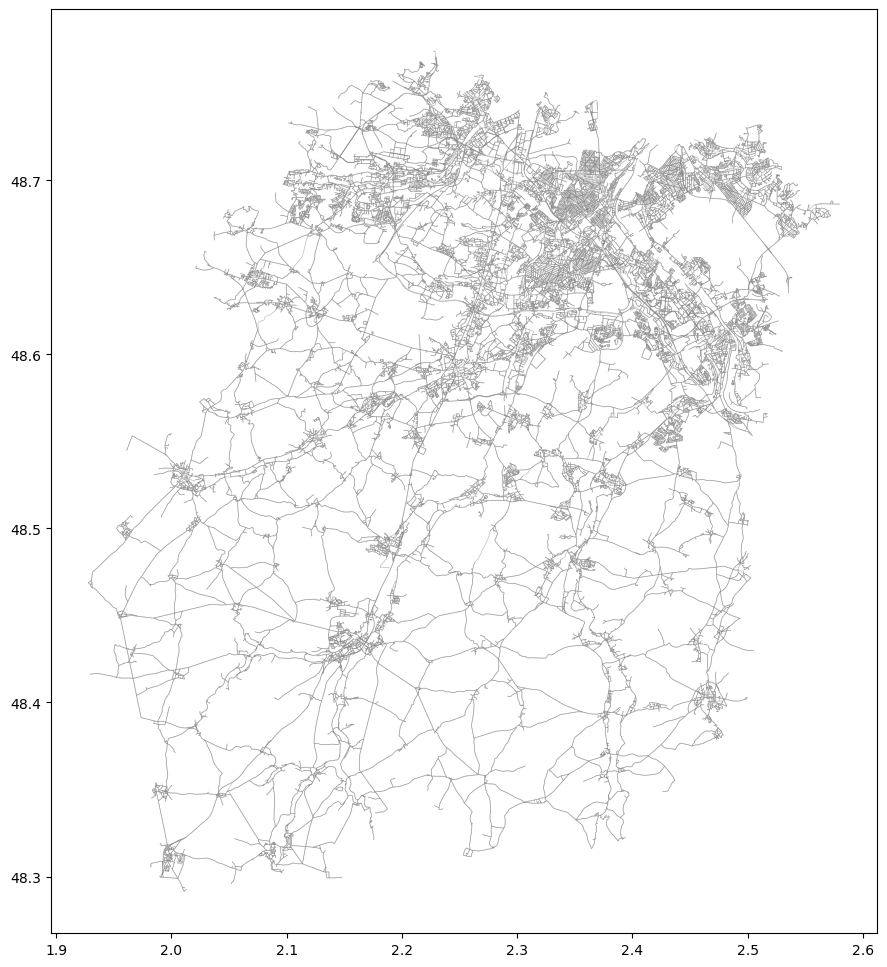

In [14]:
# Plot the routes with OSM tiles as a background
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all edges (road network)
edges = ox.graph_to_gdfs(G, nodes=False)
edges.plot(ax=ax, linewidth=0.5, edgecolor="gray", alpha=0.5)

plt.savefig("C:/Users/kangl/Desktop/données/emploi/notes/les-attractions-de-l'emploi-francilien/MOBPRO_ENTD/rassemblage/document_chapitre/chapitre3/CSMM2024/reseau.png", dpi=300, bbox_inches='tight') 
plt.show()

# mapping the assignment

In [15]:
df = car_out_essonne.loc[:20]
#df.head()

In [16]:
od_pairs = list(zip(zip(df.O_lat, df.O_long), zip(df.D_lat, df.D_long),df.IPONDI) )
#od_pairs

In [17]:
from collections import Counter
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Download the road network from OSM
G = ox.graph_from_place("Essonne, France", network_type="drive")

# Define multiple OD pairs
od_pairs = list(zip(zip(df.O_lat, df.O_long), zip(df.D_lat, df.D_long),df.IPONDI) )

# Initialize a list to store routes and a counter for edge usage
all_routes = []
edge_usage = Counter()

# Iterate through each OD pair and calculate the shortest path
for origin, destination, weight in od_pairs:
    try:
        # Find the nearest nodes to the origin and destination
        orig_node = ox.distance.nearest_nodes(G, origin[1], origin[0])
        dest_node = ox.distance.nearest_nodes(G, destination[1], destination[0])

        # Calculate the shortest path
        route = nx.shortest_path(G, orig_node, dest_node, weight="length")
        
        # Extract route edges and count their usage
        for u, v in zip(route[:-1], route[1:]):
            # Sort the nodes to count the edge undirectionally
            edge = tuple(sorted((u, v)))  
            edge_usage[edge] += weight  # Increment by the OD pair's weight
        
        # Store the route
        all_routes.append(route)

    except nx.NetworkXNoPath:
        print(f"No path found between {origin} and {destination}. Skipping this pair.")

In [18]:
#edge_usage 

epsg:4326


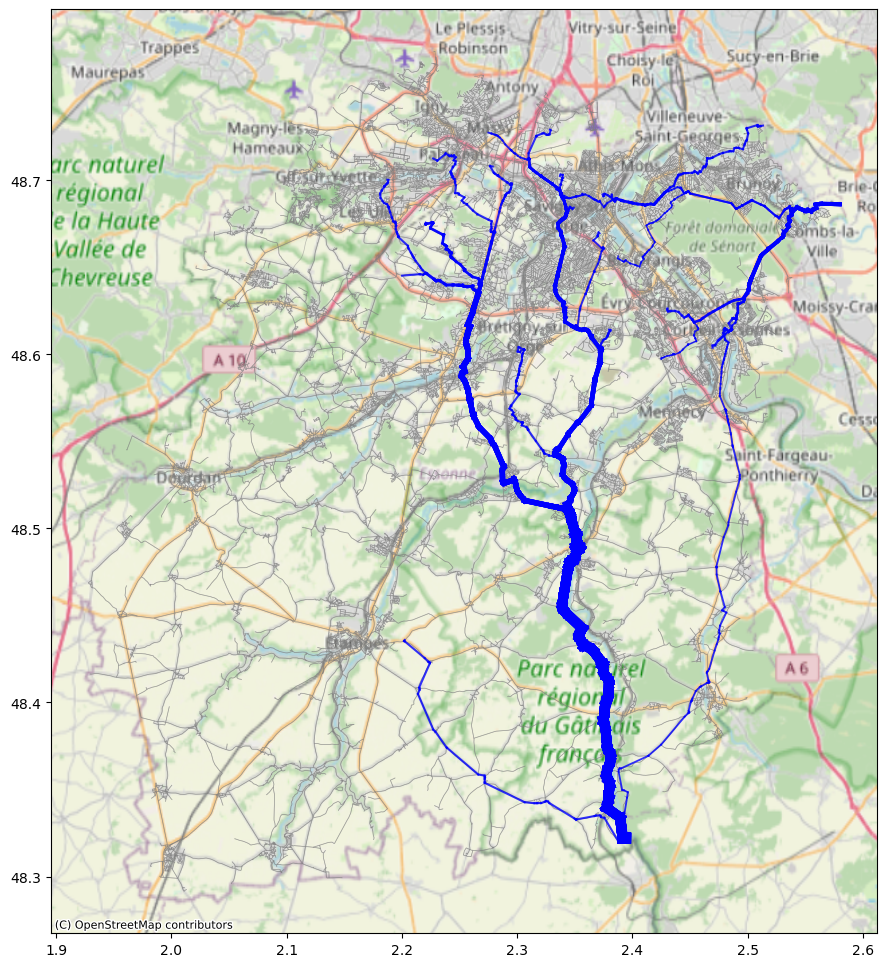

In [19]:
# Extract the CRS from the graph GeoDataFrame
edges_gdf, _ = ox.graph_to_gdfs(G)
crs = edges_gdf.crs

# Plot the traveled routes with OSM tiles as a background
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all edges (road network)
edges = ox.graph_to_gdfs(G, nodes=False)
edges.plot(ax=ax, linewidth=0.5, edgecolor="gray", alpha=0.5)

# Iterate over the OD pairs and plot only the segments in the shortest paths
for route in all_routes:
    for u, v in zip(route[:-1], route[1:]):
        # Sort the nodes to count the edge undirectionally
        edge = tuple(sorted((u, v)))  
        count = edge_usage[edge] if edge in edge_usage else 0
        geometry = G[u][v].get("geometry", None)

        if geometry is None:  # Create straight lines for missing geometry
            point1 = (G.nodes[u]["x"], G.nodes[u]["y"])
            point2 = (G.nodes[v]["x"], G.nodes[v]["y"])
            geometry = LineString([point1, point2])

        # Adjust linewidth based on the edge usage count
        ax.plot(
            [point[0] for point in geometry.coords],
            [point[1] for point in geometry.coords],
            color="blue",
            linewidth=1 + count*0.1,  # Increase width with usage
            alpha=0.8,
        )
print( edges.crs)

# Add contextily OSM basemap
ctx.add_basemap(
    ax,
    crs=edges.crs,
    source=ctx.providers.OpenStreetMap.Mapnik
)

plt.savefig("C:/Users/kangl/Desktop/données/emploi/notes/les-attractions-de-l'emploi-francilien/MOBPRO_ENTD/rassemblage/document_chapitre/chapitre3/CSMM2024/plot.png", dpi=300, bbox_inches='tight') 
plt.show()

epsg:4326


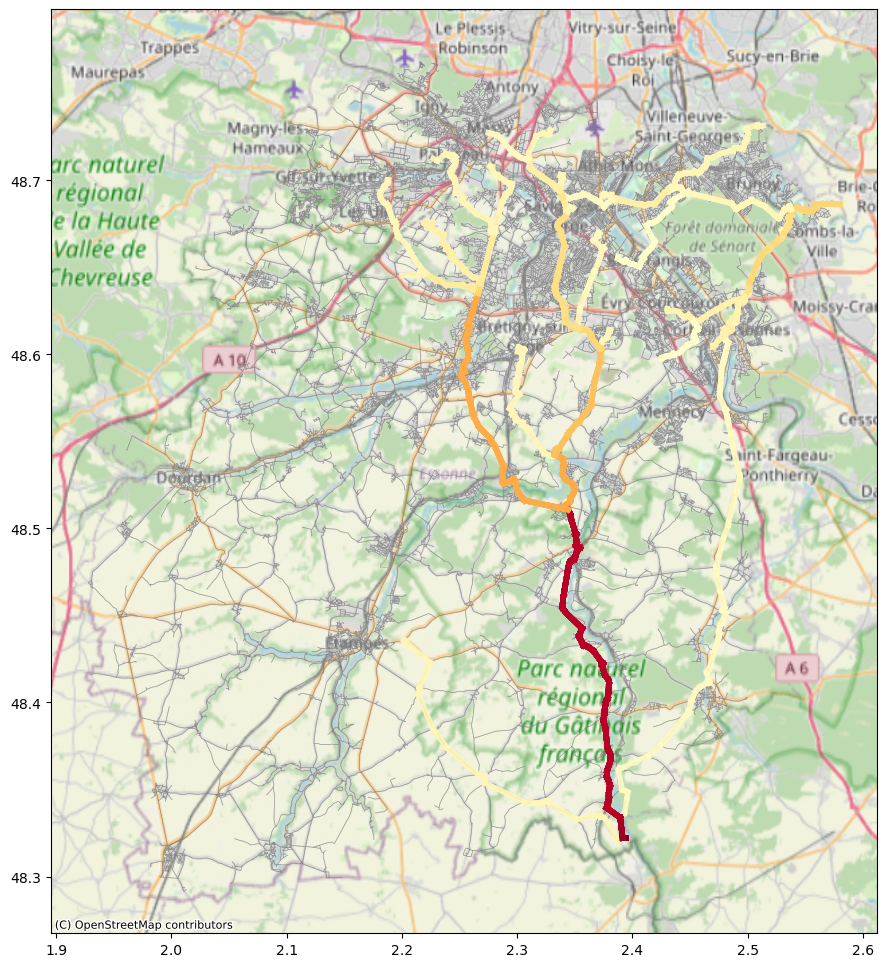

In [20]:
# Extract the CRS from the graph GeoDataFrame
edges_gdf, _ = ox.graph_to_gdfs(G)
crs = edges_gdf.crs

# Normalize edge usage counts for colormap
max_count = max(edge_usage.values()) if edge_usage else 1  # Avoid division by zero
cmap = cm.YlOrRd  # Choose a colormap (e.g., 'plasma', 'viridis')
norm = mcolors.Normalize(vmin=1, vmax=max_count)

# Plot the traveled routes with OSM tiles as a background
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all edges (road network)
edges = ox.graph_to_gdfs(G, nodes=False)
edges.plot(ax=ax, linewidth=0.5, edgecolor="gray", alpha=0.5)

# Iterate over the OD pairs and plot only the segments in the shortest paths
for route in all_routes:
    for u, v in zip(route[:-1], route[1:]):
        # Sort the nodes to count the edge undirectionally
        edge = tuple(sorted((u, v)))  
        count = edge_usage[edge] if edge in edge_usage else 0
        geometry = G[u][v].get("geometry", None)

        if geometry is None:  # Create straight lines for missing geometry
            point1 = (G.nodes[u]["x"], G.nodes[u]["y"])
            point2 = (G.nodes[v]["x"], G.nodes[v]["y"])
            geometry = LineString([point1, point2])

        # Get the color from the colormap based on the edge usage count
        color = cmap(norm(count))

        # Plot the route segment with the colormap color
        ax.plot(
            [point[0] for point in geometry.coords],
            [point[1] for point in geometry.coords],
            color=color,
            linewidth=4,
            alpha=0.9,
        )

print( edges.crs)
# Add contextily OSM basemap
ctx.add_basemap(
    ax,
    crs= edges.crs,
    source=ctx.providers.OpenStreetMap.Mapnik
)

plt.savefig("C:/Users/kangl/Desktop/données/emploi/notes/les-attractions-de-l'emploi-francilien/MOBPRO_ENTD/rassemblage/document_chapitre/chapitre3/CSMM2024/plot_0.png", dpi=300, bbox_inches='tight') 
plt.show()